# Transformers for numerai

## Credit
Through researching this approach, I've realised that Suraj Parmar has already implemented this ([medium post](https://parmarsuraj99.medium.com/era-of-transformers-792e5960e287)). Parts of the code here in structuring the input and the overall transformer structure is inspired by his code. There are variations as the transformer implementation is taken from my reimplmentation of nano-gpt [here](https://github.com/vispz/andrej_lectures/blob/main/gpt/gpt.py). 

Regardless, credits to Suraj for the idea and the awesome writeup!

## What does this notebook do differently?
We build from simple to more complex models. Why?
1. I wanted to know if neural nets can produce results similar to Gradient Boosted Trees on the numerai dataset. This is a different question from whether transformers are a good idea for this problem.
2. Does the transformer architecture improve over a simple Multi Layer Perceptron or a Fully-Connected NN?
3. Pedagogical reasons. It would be a useful exercise to build from simple to a complex network.

## Steps

1. Load the data offered by numerai. _The numerai dataset is split into eras corresponding to a specific week. Each era has features and targets for ~5k equities/stocks. Targets correspond to stock returns after residualising some macro effects._
2. Pad the dataset such that each era has a fixed number of equities.
3. Push the padded X, targets, mask into a pytorch dataloader.
4. Build baselines
    * example script, lgbm model. This is a very strong baseline; likely will not beat this performance but we can ensemble with it.
    * A simple linear model MSE(sigmoid(w@x))
5. More complex models: 2-layer and 3-layer Fully-Connected Nets
6. More complex models: Transformers
    * Attention only model
    * Transformer model with Blocks of (MultiHeaded Attention + MLP)
  
The hope is as we get to more increasingly complex model, we get better performance. It's also possible the more complex models lead to overfitting or are simply hard to train.

## Future
Convert this to a script to enable multi-gpu training.

In [453]:
from IPython.display import display
from typing import *

import copy
import gc
import itertools
import lightgbm as lgb
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numerapi
import json
import numpy as np
import scipy.stats as stats
import time
import os
import torch.utils.data as data_utils
import matplotlib.pyplot as plt

from collections import defaultdict
from tqdm.notebook import tqdm
from dataclasses import dataclass

plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update(
    {
        'legend.fontsize': 'x-large',
        'axes.labelsize': 'x-large',
        'axes.titlesize':'x-large',
        'xtick.labelsize':'x-large',
        'ytick.labelsize':'x-large',
    }
)

torch.set_default_dtype(torch.float32)

## 1. DATA LOADING

In [2]:
train_fl = "../../data/v4.1/train_int8.parquet"
val_fl = "../../data/v4.1/validation_int8.parquet"
ft_fl = "../../data/v4.1/features.json"

napi = numerapi.NumerAPI()
napi.download_dataset(filename="v4.1/train_int8.parquet", dest_path=train_fl)
napi.download_dataset(filename="v4.1/validation_int8.parquet", dest_path=val_fl)
napi.download_dataset(filename="v4.1/features.json", dest_path=ft_fl)

In [3]:
# DATA CONSTANTS

TARGETS = ["target_cyrus_v4_20", "target_waldo_v4_20", "target_ralph_v4_20"]
# Final metrics are always computed against this metric
TARGET_COL = "target_cyrus_v4_20"
# This allows for creating a weighted combination of multiple targets
TARGET_WTS = torch.tensor([1., 0., 0.])

TRAIN_FRAC = 0.7  # Fraction train vs val set
EMBARGO = 10 # Number of weeks of embargo to prevent label leakage

# Load small or all features
fts_meta = json.loads(open(ft_fl).read())
SML_FEATURES = fts_meta["feature_sets"]["small"]
MDM_FEATURES = fts_meta["feature_sets"]["medium"]
ALL_FEATURES = None
# Choose whichever size depending on testing or full training
FEATURES = SML_FEATURES

## Load dataset and pad
# E - num_eras
# S - num_stocks padded to fixed size
# F - num_features
PADDING_VALUE = -1
MAX_NSTOCKS = 6000
DEVICE = 'cuda' if torch.cuda.is_available()  else 'cpu'

# Models save dir
os.makedirs("nn_models", exist_ok=True)

In [4]:
def load_data(fl):
    if FEATURES is not None:
        df = pd.read_parquet(fl, columns=["era"] + FEATURES + TARGETS)
    else:
        df = pd.read_parquet(fl)
    df["era"] = df["era"].astype(int)
    df = df[["era"] + [c for c in df.columns if c.startswith('feature_')] + TARGETS]
    df = df.fillna(df.median())  # There can be NAs in fts and tgts
    assert not(df.isna().any().any())
    print(f"Shape: {df.shape}\t Eras: {df.era.min(), df.era.max()}")
    return df

print("Train\t", end="")
train_all_df = load_data(train_fl)
print("Test\t", end="")
test_df = load_data(val_fl)

Train	Shape: (2420521, 36)	 Eras: (1, 574)
Test	Shape: (2546387, 36)	 Eras: (575, 1073)


In [5]:
N_FEATURES = test_df.filter(like="feature").shape[1]
FEATURES = test_df.filter(like="feature").columns.to_list()

In [6]:
# Create a train and validation set. The test set will always be kept
# aside to get final validation metrics from numer.ai
n_train_all_eras = train_all_df.era.nunique()
last_train_era   = int(n_train_all_eras * TRAIN_FRAC)

train_df = train_all_df[train_all_df["era"] <= last_train_era]
val_df   = train_all_df[train_all_df["era"] >  last_train_era + EMBARGO]

# 400 eras/weeks ~8 years of training and 175 weeks of val ~3.5 years
print(f"Train\tshape: {train_df.shape}\t Eras: {train_df.era.min(), train_df.era.max()}")
print(f"Val\tshape: {val_df.shape}\t Eras: {val_df.era.min(), val_df.era.max()}")

del train_all_df
gc.collect()

Train	shape: (1625257, 36)	 Eras: (1, 401)
Val	shape: (750606, 36)	 Eras: (412, 574)


In [8]:
# This cell is very much inspired by Suraj's implementation

def pad_data(df):
    """Pad input data to create a transformer friendly input."""
    Xs, labels, masks = [], [], []
    for era, data in tqdm(df.groupby("era")):
        padded_data = convert_to_torch(data=data)
        Xs.append(padded_data["inputs"])
        labels.append(padded_data["labels"])
        masks.append(padded_data["masks"])
    return {
        "X": torch.cat(Xs, dim=0),  # E x S x F
        "labels": torch.cat(labels, dim=0),  # E x S x num_targets
        "mask": torch.squeeze(torch.cat(masks, dim=0)),  # E x S
    }

def convert_to_torch(data):
    inputs = torch.from_numpy(data[FEATURES].values.astype(np.int8))
    labels = torch.from_numpy(data[TARGETS].values.astype(np.float32))
    padded_inputs, masks_inputs = pad_sequence(
            inputs, padding_value=PADDING_VALUE, max_len=MAX_NSTOCKS
    )
    padded_labels, masks_labels = pad_sequence(
            labels, padding_value=PADDING_VALUE, max_len=MAX_NSTOCKS
    )
    return {"inputs": padded_inputs, "labels": padded_labels, "masks": masks_inputs}

def pad_sequence(inputs, padding_value, max_len):
    assert inputs.shape[0] < max_len
    padded_inputs = []
    masks = []
    pad_len = max_len - inputs.shape[0]
    padded_input = F.pad(inputs, (0, 0, 0, pad_len), value=padding_value)
    mask = torch.ones((inputs.shape[0], 1), dtype=torch.float)
    masks.append(
        torch.cat((mask, torch.zeros((pad_len, 1), dtype=torch.float)), dim=0)
    )
    padded_inputs.append(padded_input)
    return torch.stack(padded_inputs), torch.stack(masks)


train_padded = pad_data(train_df)
val_padded = pad_data(val_df)
test_padded = pad_data(test_df)

for k, v in train_padded.items():
    print(f"{k}\t{v.shape}")

  0%|          | 0/401 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/499 [00:00<?, ?it/s]

X	torch.Size([401, 6000, 32])
labels	torch.Size([401, 6000, 3])
mask	torch.Size([401, 6000])


In [9]:
# -------------------------------------------------------------------
# Pytorch Dataset and DataLoader classes
# 
# If we decide to move to multi-GPU training these would be useful.
# -------------------------------------------------------------------
@dataclass
class NmrDataset(data_utils.Dataset):

    X: torch.Tensor
    mask: torch.Tensor
    # Won't have during live data
    targets: Optional[torch.Tensor] = None
    # This is to create a weighted sum of multiple targets into a single target
    target_wts: torch.Tensor = TARGET_WTS
    device: str = DEVICE
    
    def __post_init__(self):
        super().__init__()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        """Returns (
            X, # S x F  (torch.float32)  \in {-1.0, 0, 0.25, 0.5, 0.75, 1.0}
            targets,  # S x 1 (torch.float32) \in {0, 0.25, 0.5, 0.75, 1.0} 
            mask, # S x 1 (bool)
        )
        """
        i, dvc = index, self.device
        # X convert int8 to float values btw 0-1, leave the padded values unchanged
        X = self.X[i].to(dtype=torch.float32)
        mask = self.mask[i] > 0
        X[mask] = X[mask] / 4.0
        if self.targets is not None:
            # Won't have during live data
            target = (self.targets[i] @ self.target_wts).to(dvc)
        else:
            target = None
        return X.to(dvc), target, mask.to(dvc)

In [463]:
BATCH_SIZE = 8
train_ds = NmrDataset(X=train_padded['X'], targets=train_padded['labels'], mask=train_padded['mask'])
train_dl = data_utils.DataLoader(
    dataset=train_ds,
    batch_size=BATCH_SIZE,
    sampler=None,
    shuffle=True,
    pin_memory=False,
)
val_ds = NmrDataset(X=val_padded['X'], targets=val_padded['labels'], mask=val_padded['mask'])
val_dl = data_utils.DataLoader(
    dataset=val_ds,   # Shuffle has to be set to false for test
    batch_size=BATCH_SIZE,
    sampler=None,
    shuffle=False,
    pin_memory=False,
)
test_ds = NmrDataset(X=test_padded['X'], targets=test_padded['labels'], mask=test_padded['mask'])
test_dl = data_utils.DataLoader(
    dataset=test_ds,
    batch_size=BATCH_SIZE,
    sampler=None,
    shuffle=False,  # Shuffle has to be set to false for test
    pin_memory=False,
)

batch = next(iter(train_dl))
inputs, target, mask = batch
print(f"Input({inputs.dtype}): {inputs.shape}  | Target({target.dtype}): {target.shape} | Mask({mask.dtype}): {mask.shape} ")

Input(torch.float32): torch.Size([8, 6000, 32])  | Target(torch.float32): torch.Size([8, 6000]) | Mask(torch.bool): torch.Size([8, 6000]) 


## 2. Model Training Code

In [477]:
#####################################################################################################
# MODEL TRAINING
#####################################################################################################
# ------------------------------------------------------------------------------------------------
# Metrics
# ------------------------------------------------------------------------------------------------

def corr_masked(pred, target, mask):
    """Computes Pearson corr by era and then averages era_corr, also returns sharpe.

    The operations are differentiable and hence we can optimise for corr or sharpe.

    preds:  (B, S) dtype=float32
    target: (B, S) dtype=float32
    mask:   (B, S) dtype=bool
    """
    mask = mask.type(torch.float) # B, S
    mask_sum = mask.sum(dim=1, keepdims=True) # B, 1
    masked_mat = {} # k -> (B, S) or (B, S)
    centered = {}  # k -> (B, S) or (B, S)
    unnorm_var = {} # k -> (B, 1)
    for k, mat in [("pred", pred), ("target", target)]:
        # Mean center the preds and targets
        masked_mat[k] = mat.clone()
        masked_mat[k][mask==0] = 0
        era_means = masked_mat[k].sum(dim=1, keepdims=True) / mask_sum  # B, 1
        centered[k] = (masked_mat[k] - era_means) * mask  # B, S
        # Unnormed variance
        unnorm_var[k] = (centered[k] ** 2).sum(dim=1, keepdims=True) # B, 1

    unnorm_covar = torch.sum(centered["pred"] * centered["target"], dim=1, keepdims=True)  # B, 1
    unnorm_std_prod = torch.sqrt(unnorm_var["pred"] * unnorm_var["target"])  # B, 1
    erawise_corr = unnorm_covar / unnorm_std_prod
    avg_corr = erawise_corr.mean()
    return {
        "erawise_corr": erawise_corr, # B, 1
        "corr": avg_corr, # scalar
        "sharpe": avg_corr / erawise_corr.std(), # scalar
    }


def numerai_corr_stats(eras: pd.Series, pred: pd.Series, target: pd.Series) -> float:
    """Computes numerai corr and sharpe. These operations are not differentiable.
    """
    df = pd.concat([eras, pred, target], axis=1)
    df.columns = ["era", "pred", "target"]
    with np.errstate(divide='ignore',invalid='ignore'): 
        per_era_corr = df.groupby("era").apply(lambda x: numerai_corr(x["pred"], x["target"]))
    avg_corr = per_era_corr.mean()
    return {
        "corr": avg_corr, 
        "sharpe": avg_corr / per_era_corr.std(),
    }

def numerai_corr(preds, target):
    """Numerai corr metric, lifted straight Hello Numerai tutorial notebook."""
    # rank (keeping ties) then gaussianize predictions to standardize prediction distributions
    ranked_preds = (preds.rank(method="average").values - 0.5) / preds.count()
    gauss_ranked_preds = stats.norm.ppf(ranked_preds)
    # center targets around 0
    centered_target = target - target.mean()
    # raise both preds and target to the power of 1.5 to accentuate the tails
    preds_p15 = np.sign(gauss_ranked_preds) * np.abs(gauss_ranked_preds) ** 1.5
    target_p15 = np.sign(centered_target) * np.abs(centered_target) ** 1.5
    # finally return the Pearson correlation
    return np.corrcoef(preds_p15, target_p15)[0, 1]

# ------------------------------------------------------------------------------------------------
# Training loop
# ------------------------------------------------------------------------------------------------
@dataclass(frozen=True, order=True)
class BestModel:
    """Keeps track of the best model on val set during training.

    As training progresses train metrics will improve but val set can go
    down due to overfitting. This allows for early stopping or at least
    keeping track of the best model during training.
    """
    metric: float = -float('inf')
    model: Optional[nn.Module] = None
    epoch: Optional[int] = None


class MetricsSequence:
    """Datastructure that holds {'metric_name': [metric_value]}.

    These are updated during training. Each element in the list of
    metric values could be the average of a single training batch or
    an entire epoch.
    """

    def __init__(self):
        self.m2seq: Dict[str, List[float]] = defaultdict(list)

    def append(self, metric_dict: Dict[str, float]) -> None:
        # Mutates
        for k, v in metric_dict.items():
            self.m2seq[k].append(v)

    def mean(self) -> Dict[str, float]:
        return {
            # nanmean because sharpe can be nan when only one batch era element exists
            metric: np.nanmean(value_list)
            for metric, value_list in self.m2seq.items()
        }

    @property
    def num_epochs(self) -> int:
        if not self.m2seq:
            return 0
        else:
            m = next(iter(self.m2seq))
            return len(self.m2seq[m])

    def __repr__(self):
        return ' '.join(f"{m}: {round(v,4)}" for m, v in sorted(self.mean().items()))

    @staticmethod
    def plot(mseq: 'MetricsSequence', title='', rolling_avg=True) -> None:
        m2seq = mseq.m2seq
        num_metrics = len(m2seq)
        _, axes = plt.subplots(1, num_metrics, figsize=(20,4))
        for m, ax in zip(m2seq, axes.flat):
            if rolling_avg:
                _plot_roll_avg_w_ebars(m2seq[m], ax=ax)
            else:
                ax.plot(m2seq[m], marker='o', linestyle='dashed', linewidth=2)
            ax.set_title(m)
            ax.set_xlabel("Epoch/batch")
        plt.suptitle(title, fontsize=18)
        plt.tight_layout()
        plt.show()

    @staticmethod
    def tabular(mseq: 'MetricsSequence') -> None:
        return pd.DataFrame(mseq.m2seq)


def _plot_roll_avg_w_ebars(data, ax, window_size=10, color='b', alpha=0.3):
    """Plots rolling average of data, taken from ChatGPT."""
    rolling_avg = np.convolve(data, np.ones(window_size) / window_size, mode='valid')
    std_dev = np.std([data[i:i + window_size] for i in range(len(data) - window_size + 1)], axis=1)
    ax.plot(range(window_size - 1, len(data)), rolling_avg, f'{color}-', label='Rolling Average')
    ax.fill_between(
        range(window_size - 1, len(data)),
        rolling_avg - std_dev,
        rolling_avg + std_dev,
        color=color,
        alpha=alpha,
        label='Error Bars',
    )


def calculate_metrics(outputs, target, mask):
    """Calculates metrics and losses during training. Used to take grad in backprop."""
    corr_metrics = corr_masked(pred=outputs, target=target, mask=mask)
    return {
        "mse": F.mse_loss(
            # preds: dim (S_0+S_1...+S_B, F), that is 2d matrix where the first dimension is
            # a concatenation of all the (era, stock) which were not padded
            outputs[mask],
            # preds: dim (S_0+S_1...+S_B, L), where L is the number of True target
            target[mask],
        ),
        "corr":   corr_metrics["corr"],
        "sharpe": corr_metrics["sharpe"],
    }
    

def train_on_batch(model, optimizer, batch, criterion: str, criterion_dirn: str):
    was_in_eval = not model.training
    model.train()
    inputs, target, mask = batch
    optimizer.zero_grad()
    outputs = model(inputs, mask)
    metrics = calculate_metrics(outputs=outputs, target=target, mask=mask)
    loss_dirn_mult = {"lower": 1, "higher": -1}[criterion_dirn]
    (loss_dirn_mult * metrics[criterion]).backward()
    optimizer.step()
    if was_in_eval:
        # leave the model in the same state it came in
        model.eval()
    return _pluck_item( metrics)


def _pluck_item(d: Dict[str, torch.Tensor]) -> Dict[str, float]:
    return {k: v.item() for k, v in d.items()}


@torch.no_grad()
def evaluate_on_batch(model, batch):
    was_in_train = model.training
    model.eval()
    inputs, target, mask = batch
    outputs = model(inputs, mask)
    metrics = calculate_metrics(outputs=outputs, target=target, mask=mask)
    if was_in_train:
        # leave the model in the same state it came in
        model.train()
    return _pluck_item(metrics)


def train_model(
    model,
    optimizer,
    train_dl,
    val_dl,
    num_epochs,
    # These two keep track of train and eval metrics. These are passed in so
    # that this function can be called repeatedly
    criterion: str, model_path: str,
    criterion_dirn: str,  # "lower" or "higher"
    # {"best_val_model": , "train_metrics": , "val_metrics": }
    train_state: Dict[str, Any], 
    save_every_epoch: int = 50,
):
    """The main training loop. Entrypoint for model training.
    
    :param train_state: This is passed in and returned by the training function.
        We might want to train for a few epochs inspect the model and then continue
        training. In those scenarios, this dict, keeps track of training state.
    """
    best_model = train_state["best_val_model"]
    for epoch in (pbar:= tqdm(range(num_epochs),  desc="Epoch")):
        # Training
        # --------
        model.train()
        ep_trn_metrics = MetricsSequence()
        for _, batch in tqdm(zip(range(10),train_dl), desc="Train batch", leave=False):
            ep_trn_metrics.append(
                train_on_batch(
                    model,
                    optimizer,
                    batch,
                    criterion=criterion,
                    criterion_dirn=criterion_dirn,
                )
            )
        train_state["train_metrics"].append(ep_trn_metrics.mean())
        # Evaluation
        # ----------
        model.eval()
        ep_val_metrics = MetricsSequence()
        for batch in tqdm(val_dl, desc="Eval batch", leave=False):
            ep_val_metrics.append(evaluate_on_batch(model, batch))
        avg_val_metrics = ep_val_metrics.mean()
        train_state["val_metrics"].append(avg_val_metrics)
        # Bookkeeping and cleanup
        # -----------------------
        if avg_val_metrics["corr"] > best_model.metric:
            best_model = BestModel(
                metric=avg_val_metrics["corr"],
                model=copy.deepcopy(model),
                epoch=train_state["train_metrics"].num_epochs,
            )
        pbar.set_description(
            f"Epoch \n [Train] {ep_trn_metrics} \n"
            f"[Val] {ep_val_metrics}"
        )
        torch.cuda.empty_cache()
        gc.collect()
        if model_path and epoch % save_every_epoch == 0:
            torch.save(model.state_dict(), model_path)
    return {
        "best_val_model": best_model,
        "train_metrics": train_state["train_metrics"],
        "val_metrics": train_state["val_metrics"],
    }


# ------------------------------------------------------------------------------------------------
# Predict test-set for validation diagnostics at https://numer.ai/scores
# ------------------------------------------------------------------------------------------------
def build_val_submission(model, test_df, test_dl) -> pd.DataFrame:
    preds = predict_dl(model=model, dl=test_dl).detach().numpy()
    df = pd.Series(
        predict_dl(model=model, dl=test_dl).detach().numpy(),
        index=test_df.index,
    ).reset_index()
    df.columns = ["id", "prediction"]
    # Print stats
    print(f"{test_df.shape=}, {preds.shape=}")
    corr = numerai_corr_stats(
        eras=test_df.era,
        pred=df.set_index('id'),
        target=test_df.target_cyrus_v4_20,
    )
    print(f"Corr: {corr}")
    return df


@torch.no_grad()
def predict_dl(model, dl):
    # (E*S) x 1 where (E*S) includes all era x stock pair in input data 
    return torch.concat(
        [
            predict_batch(model=model, batch=batch)
            for batch in tqdm(dl, leave=False, desc="Batches")
        ],
        dim=0,
    )

@torch.no_grad()
def predict_batch(model, batch):
    was_in_train = model.training
    model.eval()
    inputs, target, mask = batch
    preds = model(inputs, mask)
    if was_in_train:
        # leave the model in the same state it came in
        model.train()
    return preds[mask]  # (B*S'); S' only includes unpadded stocks


def summarise_model_perf(model, train_state, test_df, test_dl, model_name=""):
    display(train_state)
    MetricsSequence.plot(train_state["train_metrics"], title=f"[Train] {model_name} model")
    MetricsSequence.plot(train_state["val_metrics"], title=f"[Val] {model_name} model")
    display(MetricsSequence.tabular(train_state["val_metrics"]).tail(4))
    print("\nFinal model on test set\n-----------------------")
    # prints metrics on test set by the final model from training
    build_val_submission(model=model, test_df=test_df, test_dl=test_dl)
    print("\nBest val model on test set\n--------------------------")
    # prints metrics on test set by model that had best perf on val set during training
    build_val_submission(model=train_state["best_val_model"].model, test_df=test_df, test_dl=test_dl)
    gc.collect()

## 3. Baseline Models

In [12]:
#####################################################################################################
# BASELINE MODELS
#####################################################################################################

In [21]:
# ------------------------------------------------------------------------------------------------
# BASELINE: LGBM (Very strong baseline)
# ------------------------------------------------------------------------------------------------
sml_params = {"n_estimators": 2000,
          "learning_rate": 0.01,
          "max_depth": 5,
          "num_leaves": 2 ** 5,
          "colsample_bytree": 0.1}
lg_params =  {
    "n_estimators": 20000,
    "learning_rate": 0.001,
    "max_depth": 6,
    "num_leaves": 2**6,
    "colsample_bytree": 0.1,
}
params = sml_params
lgreg = lgb.LGBMRegressor(**params)
lgreg.fit(train_df.filter(like='feature_', axis='columns').astype(np.int8),
          train_df[TARGET_COL].astype(np.float32))

LGBMRegressor(colsample_bytree=0.1, learning_rate=0.01, max_depth=5,
              n_estimators=2000, num_leaves=32)

In [22]:
lgb_pred = pd.Series(
    lgreg.predict(test_df.filter(like='feature_', axis='columns').astype(np.int8)),
    index=test_df.index,
)
lgb_pred

id
n000101811a8a843    0.494525
n001e1318d5072ac    0.497219
n002a9c5ab785cbb    0.497831
n002ccf6d0e8c5ad    0.527595
n0051ab821295c29    0.486080
                      ...   
nff9694d7c110513    0.498292
nffa11825d8ce071    0.505869
nffa4d6e827c1ebb    0.488306
nffbcd77e22f2aa4    0.520065
nffde5e63a0ea6ca    0.484671
Length: 2546387, dtype: float64

In [25]:
numerai_corr_stats(
    eras=test_df.era,
    pred=lgb_pred,
    target=test_df[TARGET_COL],
)

{'corr': 0.0218189949898127, 'sharpe': 0.9778096312360317}

In [16]:
del train_df, val_df
gc.collect()

2290

out.shape=torch.Size([40, 6000])


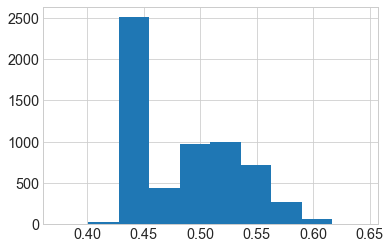

In [13]:
# ------------------------------------------------------------------------------------------------
# BASELINE: LINEAR MODEL
# ------------------------------------------------------------------------------------------------

@dataclass(eq=False)
class LinearModel(nn.Module):
    n_feats: int = N_FEATURES

    def __post_init__(self):
        super().__init__()
        self.fc = nn.Sequential(nn.Linear(self.n_feats, 1), nn.Sigmoid())

    def forward(self, X, mask):
        B, S, F = X.shape
        out = self.fc(X)  # B, S, 1
        assert tuple(out.shape) == (B, S, 1)
        return out[:,:,0]


# Build a linear model and show the prediction distribution
# ---------------------------------------------------------
lm = LinearModel().to(DEVICE)
input_, lbls, mask = next(iter(train_dl))
out = lm(input_, mask)
print(f"{out.shape=}")
preds = torch.squeeze(out[0]).detach().numpy()
# When era has fewer than 6k stocks, we pad those with -1 and predict
# a constant value for all those padded stocks. That's the spike below.
pd.Series(preds).hist();

In [15]:
# Train the linear model and see performance
# {metric -> [val_batch_1, val_batch_2...]}

# Predefine these if we want to run `train_model` multiple times
lm = LinearModel().to(DEVICE)
lm_train_state = {
    "best_val_model": BestModel(),
    "train_metrics": MetricsSequence(),
    "val_metrics": MetricsSequence(),
}

In [17]:
lm_train_state = train_model(
    model=lm,
    optimizer=optim.AdamW(lm.parameters(), lr=3e-4),
    train_dl=train_dl,
    val_dl=val_dl,
    num_epochs=100,
    criterion='corr',
    criterion_dirn='higher',
    model_path='./nn_models/linear.pkl',
    train_state=lm_train_state,
)

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

{'best_val_model': BestModel(metric=0.02899417206645012, model=LinearModel(n_feats=641), epoch=101),
 'train_metrics': corr: 0.0503 mse: 0.0515 sharpe: 2.2601,
 'val_metrics': corr: 0.0272 mse: 0.0518 sharpe: 2.4495}

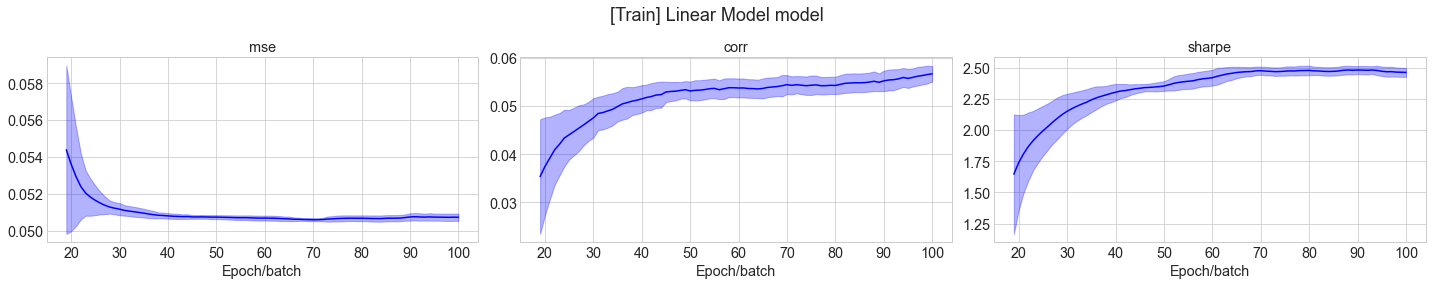

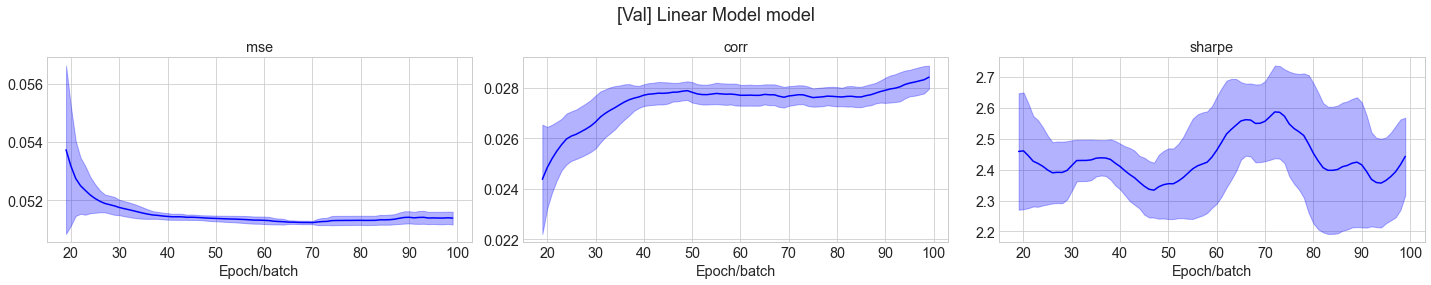

,mse,corr,sharpe
96,0.051117,0.028823,2.529862
97,0.051219,0.028785,2.596724
98,0.051401,0.028725,2.623118
99,0.051131,0.028994,2.592526



Final model on test set
-----------------------


Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Batches:   0%|          | 0/13 [00:00<?, ?it/s]

test_df.shape=(2546387, 645), preds.shape=(2546387,)
Corr: {'corr': 0.011231826532390677, 'sharpe': 0.5646525686481434}

Best val model on test set
--------------------------


Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Batches:   0%|          | 0/13 [00:00<?, ?it/s]

test_df.shape=(2546387, 645), preds.shape=(2546387,)
Corr: {'corr': 0.011231826532390677, 'sharpe': 0.5646525686481434}


In [24]:
summarise_model_perf(
    model=lm,
    train_state=lm_train_state,
    test_df=test_df,
    test_dl=test_dl,
    model_name="Linear Model",
)

In [25]:
# These are the validation metrics. As we can see a simple linear model is a lot weaker
# than an lgbm model.
lm_pred_df = build_val_submission(model=lm, test_df=test_df, test_dl=test_dl)
# We can upload this csv file to numer.ai/scores Diagnostics modal for more metrics
# lm_pred_df.to_csv("./nn_models/linear_preds.csv", index=False)

Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Batches:   0%|          | 0/13 [00:00<?, ?it/s]

test_df.shape=(2546387, 645), preds.shape=(2546387,)
Corr: {'corr': 0.011231826532390677, 'sharpe': 0.5646525686481434}


## 4. More complex Models
### 4.1 FC 2 and 3 layer models

In [54]:
#####################################################################################################
# COMPLEX MODELS
#####################################################################################################

# ------------------------------------------------------------------------------------------------
# FC - 2 LAYERS
# -------------
#
# Takeaway: Significantly better than a linear model but worse than xgb
# ------------------------------------------------------------------------------------------------
class ResidualConn(nn.Module):

    mod: nn.Module

    def __init__(self, module):
        super().__init__()
        self.module = module

    def forward(self, x):
        return self.module(x) + x


@dataclass(eq=False)
class FC(nn.Module):
    n_feats: int = N_FEATURES
    n_hidden: int = 32
    n_hidden_layers: int = 1

    def __post_init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(self.n_feats, self.n_hidden),
            nn.GELU(),
            nn.Dropout(p=0.1),
            *[
                ResidualConn(
                    module=nn.Sequential(
                        nn.Linear(self.n_hidden, self.n_hidden),
                        nn.GELU(),
                        nn.Dropout(p=0.1),
                    ),
                )
                for _ in range(self.n_hidden_layers)
            ],
            nn.Linear(self.n_hidden, 1),
            nn.Sigmoid(),
        )

    def forward(self, X, mask):
        B, S, F = X.shape
        out = self.fc(X)  # B, S, 1
        assert tuple(out.shape) == (B, S, 1)
        return out[:,:,0]

    def __repr__(self):
        return str(self.fc)

In [55]:
# --------------------------
# Fully connected 2 layer NN
# --------------------------
fc1hl = FC(n_hidden_layers=1).to(DEVICE)
print(fc1hl)
fc1hl_train_state = {
    "best_val_model": BestModel(),
    "train_metrics": MetricsSequence(),
    "val_metrics": MetricsSequence(),
}

Sequential(
  (0): Linear(in_features=641, out_features=32, bias=True)
  (1): GELU(approximate='none')
  (2): Dropout(p=0.1, inplace=False)
  (3): ResidualConn(
    (module): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): GELU(approximate='none')
      (2): Dropout(p=0.1, inplace=False)
    )
  )
  (4): Linear(in_features=32, out_features=1, bias=True)
  (5): Sigmoid()
)


In [56]:
fc1hl_train_state = train_model(
    model=fc1hl,
    optimizer=optim.AdamW(fc1hl.parameters(), lr=3e-4),
    train_dl=train_dl,
    val_dl=val_dl,
    num_epochs=50,
    criterion='corr',
    criterion_dirn='higher',
    model_path='./nn_models/fc1hl.pkl',
    train_state=fc1hl_train_state,
)

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

{'best_val_model': BestModel(metric=0.04145512878894806, model=Sequential(
   (0): Linear(in_features=641, out_features=32, bias=True)
   (1): GELU(approximate='none')
   (2): Dropout(p=0.1, inplace=False)
   (3): ResidualConn(
     (module): Sequential(
       (0): Linear(in_features=32, out_features=32, bias=True)
       (1): GELU(approximate='none')
       (2): Dropout(p=0.1, inplace=False)
     )
   )
   (4): Linear(in_features=32, out_features=1, bias=True)
   (5): Sigmoid()
 ), epoch=33),
 'train_metrics': corr: 0.0702 mse: 0.0498 sharpe: 3.364,
 'val_metrics': corr: 0.0369 mse: 0.0501 sharpe: 3.1888}

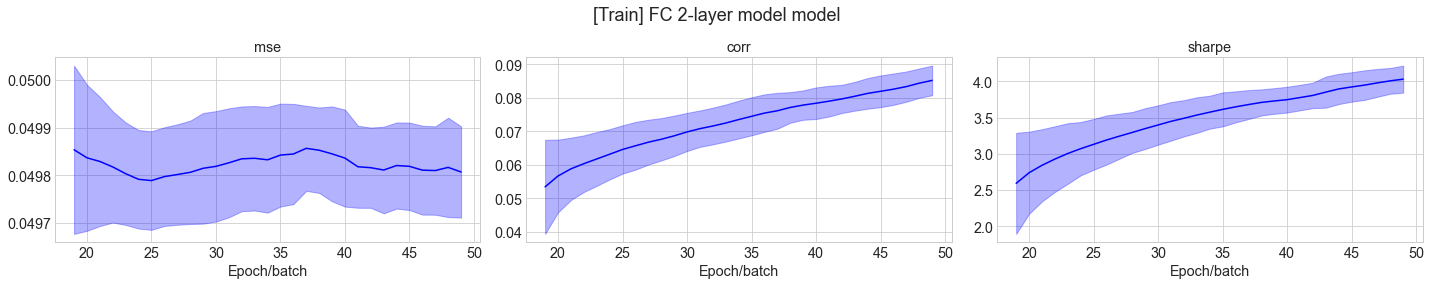

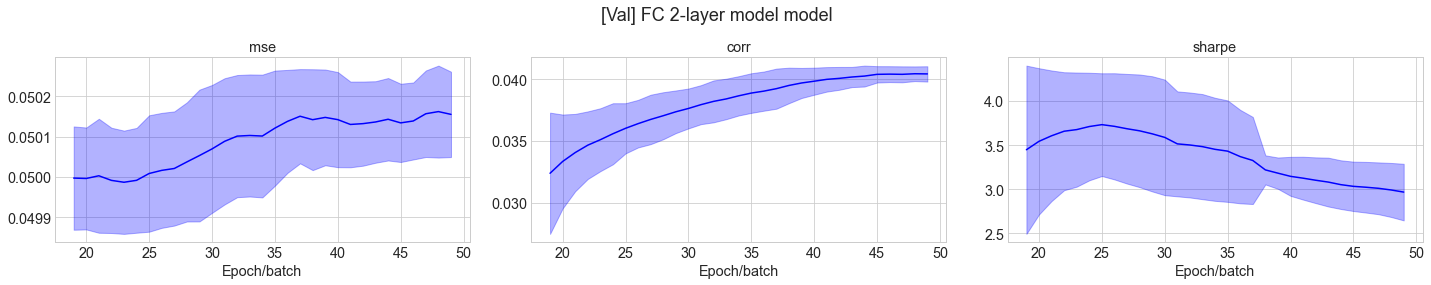

,mse,corr,sharpe
46,0.050151,0.039787,2.722797
47,0.050394,0.040135,2.743811
48,0.050353,0.040218,2.611557
49,0.050220,0.039125,2.551952



Final model on test set
-----------------------


Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Batches:   0%|          | 0/13 [00:00<?, ?it/s]

test_df.shape=(2546387, 645), preds.shape=(2546387,)
Corr: {'corr': 0.018760650946925916, 'sharpe': 0.8822053284199934}

Best val model on test set
--------------------------


Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Batches:   0%|          | 0/13 [00:00<?, ?it/s]

test_df.shape=(2546387, 645), preds.shape=(2546387,)
Corr: {'corr': 0.01817902421671469, 'sharpe': 0.8298527432079091}


In [58]:
summarise_model_perf(
    model=fc1hl,
    train_state=fc1hl_train_state,
    test_df=test_df,
    test_dl=test_dl,
    model_name="FC 2-layer model",
)

In [ ]:
fc2hl = FC(n_hidden_layers=2).to(DEVICE)
fc2hl_train_state = {
    "best_val_model": BestModel(),
    "train_metrics": MetricsSequence(),
    "val_metrics": MetricsSequence(),
}

In [ ]:
# --------------------------
# Fully connected 3 layer NN
#
# With just one hidden layer, and a residual connection we
# can get fairly close to lgbm performance
# --------------------------
fc2hl_train_state = train_model(
    model=fc2hl,
    optimizer=optim.AdamW(fc2hl.parameters(), lr=3e-4),
    train_dl=train_dl,
    val_dl=val_dl,
    num_epochs=100,
    criterion='corr',
    criterion_dirn='higher',
    model_path='./nn_models/fc2hl.pkl',
    train_state=fc2hl_train_state,
)

{'best_val_model': BestModel(metric=0.03797890469431877, model=Sequential(
   (0): Linear(in_features=641, out_features=32, bias=True)
   (1): GELU(approximate='none')
   (2): Dropout(p=0.1, inplace=False)
   (3): ResidualConn(
     (module): Sequential(
       (0): Linear(in_features=32, out_features=32, bias=True)
       (1): GELU(approximate='none')
       (2): Dropout(p=0.1, inplace=False)
     )
   )
   (4): ResidualConn(
     (module): Sequential(
       (0): Linear(in_features=32, out_features=32, bias=True)
       (1): GELU(approximate='none')
       (2): Dropout(p=0.1, inplace=False)
     )
   )
   (5): Linear(in_features=32, out_features=1, bias=True)
   (6): Sigmoid()
 ), epoch=67),
 'train_metrics': corr: 0.0844 mse: 0.0505 sharpe: 3.8842,
 'val_metrics': corr: 0.0354 mse: 0.0509 sharpe: 2.6387}

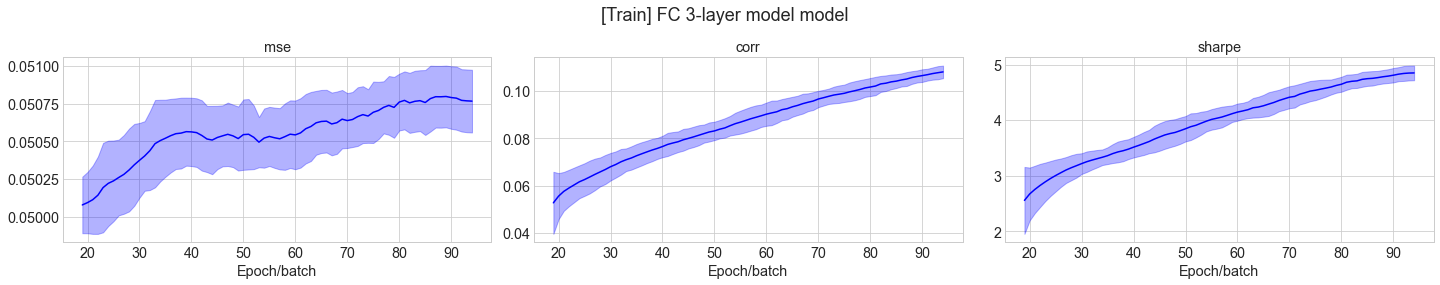

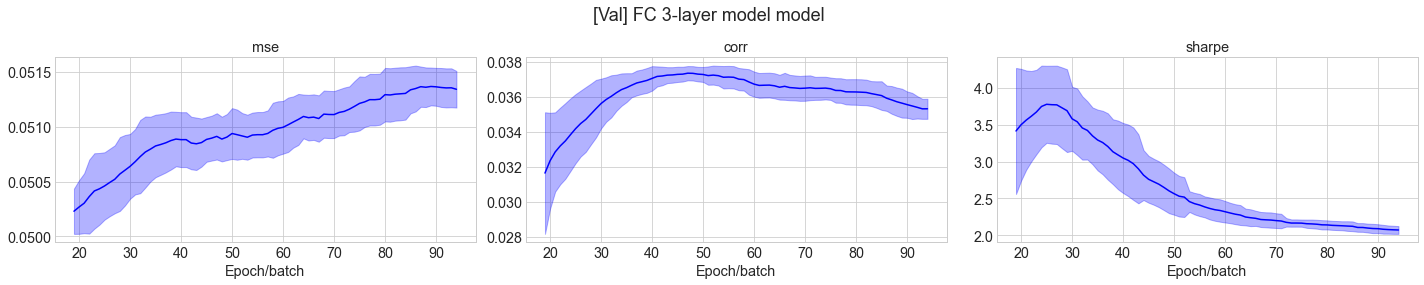

,mse,corr,sharpe
91,0.051157,0.034799,2.014651
92,0.051300,0.035582,2.090212
93,0.051274,0.034984,2.058028
94,0.051351,0.035984,2.089926



Final model on test set
-----------------------


Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Batches:   0%|          | 0/13 [00:00<?, ?it/s]

test_df.shape=(2546387, 645), preds.shape=(2546387,)
Corr: {'corr': 0.01925541562175023, 'sharpe': 0.9106698087337853}

Best val model on test set
--------------------------


Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Batches:   0%|          | 0/13 [00:00<?, ?it/s]

test_df.shape=(2546387, 645), preds.shape=(2546387,)
Corr: {'corr': 0.019661001961097182, 'sharpe': 0.8992243292647177}


In [68]:
summarise_model_perf(
    model=fc2hl,
    train_state=fc2hl_train_state,
    test_df=test_df,
    test_dl=test_dl,
    model_name="FC 3-layer model",
)

## 4.2 TRANSFORMER MODELS
Attention, MultiHeadedAttention and Full transformer models

In [434]:
# ------------------------------------------------------------------------------
# TRANSFORMERS
#
# Attention, MultiHeadedAttention and Full transformer models.
#
# Improvised rewriting of nanoGPT tutorial by Andrej K at
# https://github.com/vispz/andrej_lectures/blob/main/gpt/gpt.py
# ------------------------------------------------------------------------------

@dataclass(eq=False)
class Transformer(nn.Module):

    input_dim: int
    embed_dim: int
    num_attn_head: int
    mlp_hidden_dim: int  # embed_dim * 4 in paper
    num_blocks: int
    dropout_frac: float
    to_layer_norm: bool

    def __post_init__(self):
        super().__init__()
        bk_kwargs = dict(
            embed_dim=self.embed_dim,
            num_attn_head=self.num_attn_head,
            mlp_hidden_dim=self.mlp_hidden_dim,
            dropout_frac=self.dropout_frac,
            to_layer_norm=self.to_layer_norm,
        )
        self.net = nn.ModuleList(
            [
                nn.Linear(self.input_dim, self.embed_dim),
                *[Block(**bk_kwargs) for _ in range(self.num_blocks)],
                nn.LayerNorm(self.embed_dim) if self.to_layer_norm else nn.Identity(),
                nn.Linear(self.embed_dim, 1),
                nn.Sigmoid()
            ],
        )

    def forward(self, X, mask):
        B, S, F = X.shape
        x = X
        for subnet in self.net:
            if isinstance(subnet, Block):
                x = subnet(X=x, mask=mask)
            else:
                x = subnet(x)
        assert tuple(x.shape) == (B, S, 1)
        return x[:,:,0]

    def __repr__(self) -> str:
        return str(self.net)


@dataclass(eq=False)
class Block(nn.Module):

    embed_dim: int
    num_attn_head: int
    mlp_hidden_dim: int
    dropout_frac: float
    to_layer_norm: bool

    def __post_init__(self):
        super().__init__()
        ln_cls = nn.LayerNorm if self.to_layer_norm else nn.Identity
        self.sa = MultiHeadedAttention(
            nhead=self.num_attn_head,
            embed_dim=self.embed_dim,
            dropout_frac=self.dropout_frac,
        )
        self.ln1 = ln_cls(self.embed_dim)
        self.mlp = MLP(
            embed_dim=self.embed_dim,
            hidden_dim=self.mlp_hidden_dim,
            dropout_frac=self.dropout_frac,
        )
        self.ln2 = ln_cls(self.embed_dim)

    def forward(self, X, mask):
        attn = X + self.sa(X=self.ln1(X), mask=mask)
        out = attn + self.mlp(self.ln2(attn))
        return out

    def __repr__(self) -> str:
        return (
            f"Block(\n{self.sa},\n{self.ln1},\n{self.mlp},\n{self.ln2}\n)"
        )


@dataclass(eq=False)
class MLP(nn.Module):

    embed_dim: int
    hidden_dim: int
    dropout_frac: float

    def __post_init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(self.embed_dim, self.hidden_dim),
            nn.GELU(),
            nn.Linear(self.hidden_dim, self.embed_dim),
            nn.Dropout(self.dropout_frac),
        )

    def forward(self, X):
        return self.net(X)

    def __repr__(self) -> str:
        return str(self.net).replace("Sequential", "MLP")


@dataclass(eq=False)
class MultiHeadedAttention(nn.Module):

    """This takes in the B x S [Batch(eras) x Stocks] or output of the previous
    enccoder layer (B x Sx C) and then produces (B x S x (nhead*(out_dim/nhead)))
    output.

    We create nhead attention heads each mapping C -> (out_dim/nhead) space.
    """

    nhead: int
    embed_dim: int
    dropout_frac: float

    def __post_init__(self):
        super().__init__()
        assert (
            self.embed_dim % self.nhead == 0
        ), "Embedding dim not divisible num attention heads"
        self.heads = nn.ModuleList(
            [
                AttentionHead(
                    input_dim=self.embed_dim,
                    output_dim=self.embed_dim // self.nhead,
                    dropout_frac=self.dropout_frac,
                )
                for _ in range(self.nhead)
            ],
        )
        self.projection = nn.Linear(self.embed_dim, self.embed_dim)
        self.dropout_lyr = nn.Dropout(self.dropout_frac)

    def forward(self, X, mask):
        # concat nhead of dims B x S x E/nhead
        attn = torch.cat([h(X=X, mask=mask) for h in self.heads], dim=-1)
        out = self.dropout_lyr(self.projection(attn))  # B x S x E
        # Force the predictions of padded outputs to be 0.
        out[~mask, :] = 0.
        return out

@dataclass(eq=False)
class AttentionHead(nn.Module):

    """A single attention head implementation.

    This takes in the batch(eras) x Stocks x (features or output of the previous
    encoder layer (B x S x C)) and then produces (B x S x embed_dim) output. Where
    each (b, s) outputs a weighted value vector. The (b, s) example looks at all other
    stocks (b, :) computes attention scores ie., softmax(query[s]@key[:]) and computes
    a weighted sum of the value vectors.
    """

    input_dim: int
    output_dim: int
    dropout_frac: float

    def __post_init__(self):
        super().__init__()
        lin_kwargs = dict(
            in_features=self.input_dim, out_features=self.output_dim, bias=False
        )
        self.key = nn.Linear(**lin_kwargs)
        self.query = nn.Linear(**lin_kwargs)
        self.value = nn.Linear(**lin_kwargs)
        # Keep the initial softmax fairly diffused so that we look at all the stocks
        for nm, param in self.key.named_parameters():
            if nm != "weight":
                continue
            param.data *= 0.01
        self.dropout = nn.Dropout(self.dropout_frac)

    def forward(self, X, mask):
        return AttentionHead._forward(
            X=X,
            mask=mask,
            key=self.key,
            query=self.query,
            value=self.value,
            dropout=self.dropout,
            output_dim=self.output_dim,
        )

    @staticmethod
    def _forward(X, mask, key, query, value, dropout, output_dim):
        # X : B x S x D(feats), outputs B x S x E (embed_dim)
        B, S, D = X.shape
        keys, queries, values = key(X), query(X), value(X)  # B,S,E
        attn_logit = (
            # Div by sqrt(out_dim) to keep std() at the same scale as input
            torch.einsum("ijk,ilk->ijl", queries, keys) / output_dim**0.5
        )  # B x S x S
        # Mask provides which stock indices are real. We want to zero out
        # padded indices
        attn_logit[~mask, :] = -torch.inf
        attn_logit.transpose(2,1)[~mask, :] = -torch.inf
        affinities = dropout(F.softmax(attn_logit, dim=2))  # B,S,S
        # The rows of padded columns are all 0s, when taking softmax
        # we want to set them to 0, so that their output is always 0
        affinities[~mask, :] = 0.
        out = affinities @ values  # B,S,S @ B,S,E = B,S,E
        return out


In [445]:
# --------------------------
# Attention only model
# --------------------------
@dataclass(eq=False)
class AttentionModel(nn.Module):
    input_dim: int
    output_dim: int
    dropout_frac: int

    def __post_init__(self):
        super().__init__()
        self.ah = AttentionHead(
            input_dim=self.input_dim,
            output_dim=self.output_dim,
            dropout_frac=self.dropout_frac,
        )
        self.act = nn.Sigmoid()
    
    def forward(self, X, mask):
        B, S, D = X.shape
        out = self.act(self.ah(X=X, mask=mask))
        assert tuple(out.shape) == (B, S, 1)
        return out[:,:,0]

    def __repr__(self):
        return f"Sigmoid({self.ah})"


attn_ts = {
    "best_val_model": BestModel(),
    "train_metrics": MetricsSequence(),
    "val_metrics": MetricsSequence(),
}
attn = AttentionModel(
    input_dim=N_FEATURES,
    output_dim=1,
    dropout_frac=0.1,
).to(DEVICE)

In [ ]:
attn_ts = train_model(
    model=attn,
    optimizer=optim.AdamW(attn.parameters(), lr=3e-4),
    train_dl=train_dl,
    val_dl=val_dl,
    num_epochs=40,
    criterion='corr',
    criterion_dirn='higher',
    model_path='./nn_models/attn.pkl',
    train_state=attn_ts,
)
gc.collect()

{'best_val_model': BestModel(metric=0.028018762656886662, model=Sigmoid(AttentionHead(input_dim=32, output_dim=1, dropout_frac=0.1)), epoch=94),
 'train_metrics': corr: 0.0224 mse: 0.0498 sharpe: 1.1495,
 'val_metrics': corr: 0.019 mse: 0.0498 sharpe: 1.9907}

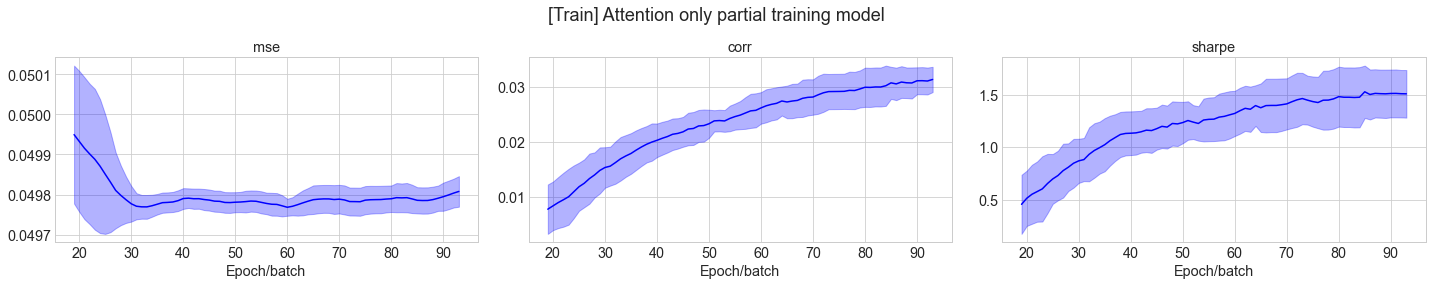

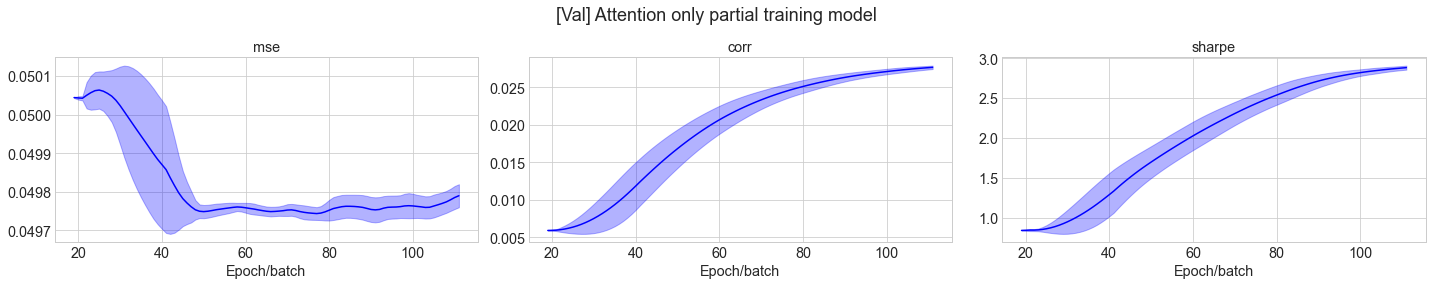

,mse,corr,sharpe
108,0.049811,0.027880,2.904573
109,0.049832,0.027921,2.909938
110,0.049848,0.027973,2.917476
111,0.049833,0.028019,2.923848



Final model on test set
-----------------------


Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

test_df.shape=(2546387, 36), preds.shape=(2546387,)
Corr: {'corr': 0.00972301114838203, 'sharpe': 0.4587941426453222}

Best val model on test set
--------------------------


Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

test_df.shape=(2546387, 36), preds.shape=(2546387,)
Corr: {'corr': 0.00972301114838203, 'sharpe': 0.4587941426453222}


In [467]:
summarise_model_perf(
    model=attn,
    train_state=attn_ts,
    test_df=test_df,
    test_dl=test_dl,
    model_name="Attention only partial training",
)

In [471]:
# --------------------------
# Transformer model
# --------------------------
tfm_train_state = {
    "best_val_model": BestModel(),
    "train_metrics": MetricsSequence(),
    "val_metrics": MetricsSequence(),
}
tfm = Transformer(
    input_dim=N_FEATURES,
    embed_dim=4,
    num_attn_head=2,
    mlp_hidden_dim=8,
    num_blocks=1,
    dropout_frac=0.1,
    to_layer_norm=False,
).to(DEVICE)
# if "./nn_models/tfm.pkl" in os.listdir():
#     transformer.load_state_dict(torch.load("./nn_models/tfm.pkl"))
tfm

ModuleList(
  (0): Linear(in_features=32, out_features=4, bias=True)
  (1): Block(
  MultiHeadedAttention(nhead=2, embed_dim=4, dropout_frac=0.1),
  Identity(),
  MLP(
    (0): Linear(in_features=4, out_features=8, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=8, out_features=4, bias=True)
    (3): Dropout(p=0.1, inplace=False)
  ),
  Identity()
  )
  (2): Identity()
  (3): Linear(in_features=4, out_features=1, bias=True)
  (4): Sigmoid()
)

In [ ]:
tfm_train_state = train_model(
    model=tfm,
    optimizer=optim.AdamW(tfm.parameters(), lr=3e-4),
    train_dl=train_dl,
    val_dl=val_dl,
    num_epochs=40,
    criterion='corr',
    criterion_dirn='higher',
    model_path='./nn_models/tfm.pkl',
    train_state=tfm_train_state,
)

{'best_val_model': BestModel(metric=-0.007974565697146491, model=ModuleList(
   (0): Linear(in_features=32, out_features=4, bias=True)
   (1): Block(
   MultiHeadedAttention(nhead=2, embed_dim=4, dropout_frac=0.1),
   Identity(),
   MLP(
     (0): Linear(in_features=4, out_features=8, bias=True)
     (1): GELU(approximate='none')
     (2): Linear(in_features=8, out_features=4, bias=True)
     (3): Dropout(p=0.1, inplace=False)
   ),
   Identity()
   )
   (2): Identity()
   (3): Linear(in_features=4, out_features=1, bias=True)
   (4): Sigmoid()
 ), epoch=3),
 'train_metrics': corr: -0.0036 mse: 0.072 sharpe: -0.2347,
 'val_metrics': corr: -0.0014 mse: 0.0713 sharpe: 0.9345}

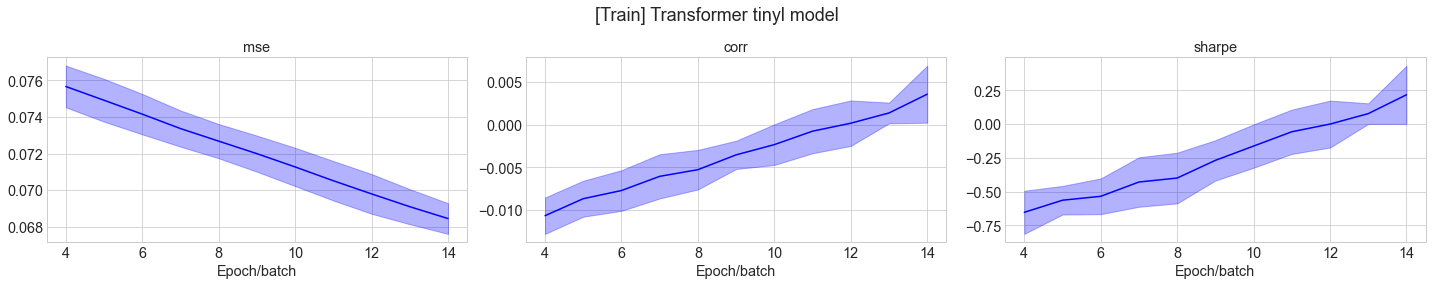

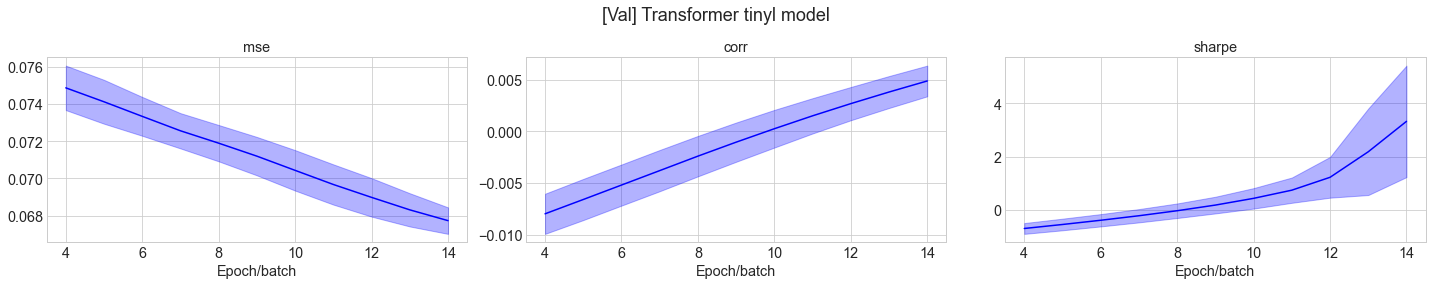

,mse,corr,sharpe
11,0.068171,0.003843,1.479853
12,0.067676,0.004904,2.563451
13,0.067182,0.005963,5.175566
14,0.066832,0.006934,6.374494



Final model on test set
-----------------------


Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

test_df.shape=(2546387, 36), preds.shape=(2546387,)
Corr: {'corr': 0.0014027638345967708, 'sharpe': 0.07618739065051013}

Best val model on test set
--------------------------


Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

test_df.shape=(2546387, 36), preds.shape=(2546387,)
Corr: {'corr': -0.003948656753321279, 'sharpe': -0.2557160122043845}


In [478]:
summarise_model_perf(
    model=tfm,
    train_state=tfm_train_state,
    test_df=test_df,
    test_dl=test_dl,
    model_name="Transformer tinyl",
)

In [479]:
gc.collect()

8193

# Test

In [302]:
def test_corr_masked():
    """Compare the above implementation with an iterative numpy implementation"""
    # Given padded inputs and targets where each row is an era and each
    # column is a stock's model's prediction or label or padding mask
    B, S = 4, 5000  # batchsize (eras) and num_stock
    pred = np.random.random((B, S))
    target = np.random.random((B, S))
    mask = np.random.random((B, S)) > 0.3
    # When we compute erawise pearson corr with the label
    res = corr_masked(
        pred=torch.from_numpy(pred),
        target=torch.from_numpy(target),
        mask=torch.from_numpy(mask),
    )
    # Then we should compute pearson corr after masking
    res_corr = res["erawise_corr"].detach().numpy()
    for  _rcorr, _o, _l, _m in zip(res_corr, pred, target, mask):
        np.testing.assert_almost_equal(_rcorr[0], np.corrcoef(_o[_m], _l[_m])[0,1])

test_corr_masked()

In [480]:
def test_attn_w_mask():
    # Given some input data of B eras and padded
    # S stocks and D features
    B, S, D = 3, 60, 4
    X = torch.randn(B, S, D)
    mask = torch.ones(B, S)
    # Stocks after these are padded
    era2stk_cnt = {0: 40, 1: 50, 2: 30}
    for era, stk_cnt in era2stk_cnt.items():
        mask[era,stk_cnt:] = 0
    mask = mask > 0
    # And a MultiHeadAttention Model
    attn = MultiHeadedAttention(
        embed_dim=D,
        nhead=4,
        dropout_frac=0.1,
    )
    # When we forward through the layer
    out = attn(X=X, mask=mask)
    # Then the output should be of expected dimensions
    assert tuple(out.shape) == (B, S, D)
    # And have 0 predictions only for the padded stocks
    for era, era_out in enumerate(out):
        assert tuple(era_out.shape) == (S, D)
        nstk = era2stk_cnt[era]
        # All the non padded stocks should have non NaN preds
        assert not torch.isnan(era_out[:nstk, :]).any()
        # All the padded stocks should have NaN preds
        assert (era_out[nstk:, :]==0.).all()

test_attn_w_mask()